# Figure 3: CDKs

This notebook produces the first panels of Figure 3.

In [1]:
import collections
import stylia
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np

from stylia import TWO_COLUMNS_WIDTH, ONE_COLUMN_WIDTH


df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]
db = df[df["l2fc"] >= 2.3]
db = db[db["l2fcM"] >= 1]
db = db[db["ml10p"] > -np.log10(0.05)]
db = db[db["ml10adjP"] > -np.log10(2.5)]
db = db[db["rankRel"] < 500]

with open("../data/pid2name_primary.tsv", "r") as f:
    pid2name = {}
    name2pid = {}
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]
        name2pid[r[1]] = r[0]

prot_counts = collections.defaultdict(int)
for r in list(db["accession"]):
    prot_counts[r] += 1

cmap_types = stylia.colors.ContinuousColorMap(
    stylia.colors.NamedColorMaps().spectral, transformation=None
)
cmap_types.fit([0,1,2,3,4])

def counts_categorizer(pid):
    v = prot_counts[pid]
    if v < 4:
        return 0
    if v < 10:
        return 1
    if v < 20:
        return 2
    if v < 40:
        return 3
    return 4

def volcano_plot(ax, fid):
    import matplotlib as mpl
    db_ = db[db["fragId"] == fid]
    df_ = df[df["fragId"] == fid]
    prots = set(db_["accession"])
    df_ = df_[~df_["accession"].isin(prots)]
    x = np.array(df_["l2fc"])
    y = np.array(df_["ml10p"])
    ax.scatter(x,y, s=0.5, color="lightgray", alpha=0.5, lw=0)
    ax.axvline(0, color="black", lw=0.5)
    ax.axhline(0, color="black", lw=0.5)
    x = np.array(db_["l2fc"])
    y = np.array(db_["ml10p"])
    pids = list(db_["accession"])
    c = np.array([counts_categorizer(p) for p in pids])
    idxs = np.argsort(c)[::-1]
    x = x[idxs]
    y = y[idxs]
    c = c[idxs]
    c = cmap_types.transform(c)
    ax.scatter(x,y, s=5, c=c, alpha=0.5, lw=0)    
    ax.set_xlabel("FC (Log2)")
    ax.set_xlabel("")
    ax.set_ylabel("P-value (-Log10)")
    ax.set_title("Fragment {0}".format(fid))
    ax.set_title("")
    xticks = [0, 2, 4, 6]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,va="top", ha="center")
    yticks = [0, 2, 4, 6]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, va="center", ha="left")
    ax.text(5, 0.5, "{0} hits".format(db_.shape[0]), color="black", va="center", ha="center", fontsize=6)

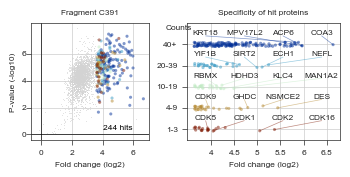

In [2]:
cdks = []
for i in range(20):
    n = i + 1
    if n == 11:
        cdks += ["CDK11A", "CDK11B"]
    else:
        cdks += ["CDK{0}".format(n)]

def strip_plot(ax, fid, gene_names):
    db_ = db[db["fragId"] == fid]
    R = []
    for r in db_[["l2fc", "accession"]].values:
        c = counts_categorizer(r[1])
        v = r[0]
        g = pid2name[r[1]]
        R += [[g, v, c]]
    d = pd.DataFrame(R, columns=["Protein", "Log2FC", "Counts"])
    jitters = np.random.uniform(-0.1, 0.1, d.shape[0])
    d["JitterCounts"] = [c+jitters[i] for i, c in enumerate(list(d["Counts"]))]
    palette = cmap_types.transform([0,1,2,3,4])
    colors = cmap_types.transform(list(d["Counts"]))
    ax.scatter(x=list(d["Log2FC"]), y=list(d["JitterCounts"]), c=colors, alpha=0.5, s=5, lw=0)
    xlim = ax.get_xlim()
    rng = xlim[1] - xlim[0]
    f = 0.12
    n = 4
    intervals = np.linspace(xlim[0]+rng*f, xlim[1]-rng*f, n)[::-1]
    for c in [0,1,2,3,4]:
        ds = d[d["Counts"] == c]
        ds = ds.sort_values(by="Log2FC", ascending=False)
        ds_0 = ds[ds["Protein"].isin(gene_names)]
        if ds_0.shape[0] >= n:
            ds = ds_0.head(n)
        else:
            ds = ds[~ds["Protein"].isin(gene_names)]
            ds_1 = ds.head(n-ds_0.shape[0])
            ds = pd.concat([ds_0, ds_1]).sort_values(by="Log2FC", ascending=False)
        for i, r in enumerate(ds[["Protein", "Log2FC", "JitterCounts"]].values):
            ax.text(intervals[i], c+0.55, r[0], ha="center", va="center", fontsize=6)
            ax.plot([r[1], intervals[i]], [r[2], c+0.40], color=palette[c], lw=0.5, alpha=0.5)
        #ax.text(0.5*(xlim[0]+xlim[1]), c-0.25, "n = {0}".format(n), ha="center", va="center", color=palette[c], fontsize=6)
    ax.set_ylabel("Fragments", fontsize=6)
    ax.set_xlabel("FC (Log2)", fontsize=6)
    ax.set_xlabel("")
    ax.set_title("Enriched proteins (N = {0})".format(d.shape[0]))
    ax.set_title("")
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(["1-3", "4-9", "10-19", "20-39", "40+"], ha="right", va="center", rotation=0)
    ax.set_ylim(-0.5, 5)
    xticks = [4, 4.5, 5, 5.5, 6, 6.5]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, va="top", ha="center")
    ax.yaxis.set_label_position("right")
    ax.text(3,4.7,"Counts", fontsize=6)

fid = "C391"

fig, axs = stylia.create_figure(nrows = 1, ncols=2, width=ONE_COLUMN_WIDTH, height=ONE_COLUMN_WIDTH/2, width_ratios=[1,1.3])
ax = axs.next()
volcano_plot(ax, fid)
stylia.label(ax, title="Fragment "+fid, xlabel="Fold change (log2)", ylabel="P-value (-log10)")

ax = axs.next()
strip_plot(ax, fid, cdks)
stylia.label(ax, title="Specificity of hit proteins", xlabel="Fold change (log2)")

stylia.save_figure("../assets/Figure03_A.png")
stylia.save_figure("../assets/Figure03_A.pdf")

In [3]:
from matplotlib.patches import Rectangle
from stylia import ContinuousColorMap, NamedColors

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]
db = df[df["l2fc"] >= 2.3]
db = db[db["l2fcM"] >= 1]
db = db[db["ml10p"] > -np.log10(0.05)]
db = db[db["ml10adjP"] > -np.log10(2.5)]
db = db[db["rankRel"] < 500]

hek_proteome = []
with open("../data/hek293t_core.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        hek_proteome += [r[0]]

human_proteome = []
with open("../data/human_proteome.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        human_proteome += [r[0]]

dp = pd.read_csv("../data/human_proteome_with_gene_names.tab", sep="\t")
name2pid = {}
for r in dp[["Entry", "Gene names  (primary )"]].values:
    name2pid[r[1]] = r[0]

def detected_proteins(fid):
    return df[df["fragId"] == fid]["accession"].tolist()

def hit_proteins(fid):
    return db[db["fragId"] == fid]["accession"].tolist()

c391_detected_proteome = detected_proteins("C391")
c391_hit_proteome = hit_proteins("C391")

df = pd.read_csv("../data/finalScreen.tsv", sep="\t")
df = df[df["nUniq"] >= 2]

kinase_term = []
with open("../data/cemm_interest_protein_class.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        if r[1] == "Kinase":
            kinase_term += [r[0]]

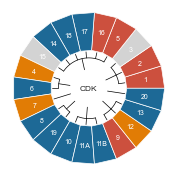

In [4]:
cdks = []
for i in range(20):
    n = i + 1
    if n == 11:
        cdks += ["CDK11A", "CDK11B"]
    else:
        cdks += ["CDK{0}".format(n)]

def cdk_donut(ax):
    labels = ["1", "2", "3", "5", "16", "17", "18", "14", "15", "4", "6", "7", "8", "19", "10", "11A", "11B", "9", "12", "13", "20"]
    x = np.linspace(0, 2*np.pi, 22)
    width = x[1]-x[0]
    c = NamedColors()
    cmap = [c.gray, c.blue, c.orange, c.red]
    colors = []
    for l in labels:
        n = "CDK"+l
        pid = name2pid[n]
        if pid in c391_hit_proteome:
            colors += [cmap[3]]
            continue
        if pid in c391_detected_proteome:
            colors += [cmap[2]]
            continue
        if pid in hek_proteome:
            colors += [cmap[1]]
            continue
        colors += [cmap[0]]
    for i in range(len(labels)):
       r = Rectangle((x[i], 0.5), width=width, height=0.5, lw=0.5, facecolor=colors[i], edgecolor="white")
       ax.add_patch(r)
       ax.text(x[i]+width/2, 0.75, labels[i], va="center", ha="center", color="white")
    
    def hphylogeny_line(x):
        x = x+(width/2)
        x = np.linspace(x[0], x[-1], 100)
        ax.plot(x, [0.4]*len(x), lw=0.5, color="black")
        
    def vphylogeny_line(x):
        x += width/2
        ax.plot([x, x], [0.4, 0.48], lw=0.5, color="black")

    def fphylogeny_line(x):
        x += width/2
        ax.plot([x, x], [0.25, 0.48], lw=0.5, color="black")

    def rphylogeny_line(x):
        x += width/2
        ax.plot([x, x], [0.25, 0.4], lw=0.5, color="black")

    hphylogeny_line(x[0:3])
    for x_ in x[0:3]:
        vphylogeny_line(x_)
    rphylogeny_line(x[1])
    hphylogeny_line(x[3:9])
    for x_ in x[3:9]:
        vphylogeny_line(x_)
    rphylogeny_line(x[5]+width/2)
    hphylogeny_line(x[9:11])
    for x_ in x[9:11]:
        vphylogeny_line(x_)
    rphylogeny_line(x[9]+width/2)
    fphylogeny_line(x[11])
    hphylogeny_line(x[12:14])
    for x_ in x[12:14]:
        vphylogeny_line(x_)
    rphylogeny_line(x[12]+width/2)
    hphylogeny_line(x[14:17])
    for x_ in x[14:17]:
        vphylogeny_line(x_)
    rphylogeny_line(x[15])
    hphylogeny_line(x[17:20])
    for x_ in x[17:20]:
        vphylogeny_line(x_)
    rphylogeny_line(x[18])
    fphylogeny_line(x[20])
    ax.axes.set_axis_off()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticklabels("")
    ax.set_title("")
    ax.grid()
    ax.text(0,0, "CDK", fontsize=stylia.FONTSIZE, ha="center", va="center")

def enrichment_plot(ax):
    stylia.label(ax, xlabel="Ranked proteins")


fig = plt.figure(figsize=(ONE_COLUMN_WIDTH/2, ONE_COLUMN_WIDTH/2))
ax = fig.add_subplot(projection="polar")
ax = stylia.figure.figure.stylize(ax)
cdk_donut(ax)

stylia.save_figure("../assets/Figure03_B.png")
stylia.save_figure("../assets/Figure03_B.pdf")

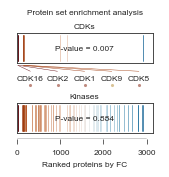

In [5]:
fig, axs = stylia.create_figure(1,1, width=ONE_COLUMN_WIDTH/2.1, height=ONE_COLUMN_WIDTH/2)
ax = axs.next()
cdks = pd.read_csv("../data/cdks.tsv", sep="\t")

def cdk_enrichment(ax):
    data = df[df["fragId"] == "C391"][["accession", "l2fc"]]
    data = data.sort_values("l2fc", ascending=False)
    pids = data["accession"].tolist()
    my_cdks = []
    cdks_set = set(cdks["uniprot_ac"])
    kinase_set = set(kinase_term)
    
    ax.plot([0,len(pids)-1], [0.7, 0.7], color="black")
    ax.plot([0,len(pids)-1], [1, 1], color="black")
    ax.plot([0,0], [0.7, 1], color="black")
    ax.plot([len(pids)-1,len(pids)-1], [0.7, 1], color="black")

    ax.plot([0,len(pids)-1], [0, 0], color="black")
    ax.plot([0,len(pids)-1], [0.3, 0.3], color="black")
    ax.plot([0,0], [0, 0.3], color="black")
    ax.plot([len(pids)-1,len(pids)-1], [0, 0.3], color="black")
    ax.set_yticklabels("")

    cmap = ContinuousColorMap("coolwarm", transformation="normal")
    cmap.fit([i for i in range(len(pids))])
    colors = cmap.transform([i for i in range(len(pids))])
    colors = colors[::-1]

    cdks_idxs = {}
    for i, p in enumerate(pids):
        if p in cdks_set:
            my_cdks += [pid2name[p]]
            cdks_idxs[pid2name[p]] = i
            ax.plot([i,i], [0.72, 0.98], color=colors[i], lw=0.5, alpha=1)
            
        if p in kinase_set:
            ax.plot([i,i], [0.02, 0.28], color=colors[i], lw=0.5, alpha=1)
    
    n = len(pids)
    
    label_pos = np.linspace(0+n*0.1, len(pids)-n*0.1, 5)
    c = np.array([counts_categorizer(name2pid[p]) for p in my_cdks])
    colors_ = cmap_types.transform(c)
    for i, p in enumerate(label_pos):
        ax.text(p, 0.55, my_cdks[i], va="center", ha="center", fontsize=6)
        x = cdks_idxs[my_cdks[i]]
        ax.plot([x, p], [0.68, 0.62], color=colors[x], lw=0.3)
        ax.scatter([p], [0.48], color=colors_[i], alpha=0.5, s=5, lw=0)

    ax.text(n/2, 1.07, "CDKs", va="center", ha="center", fontsize=6)
    ax.text(n/2, 0.85, "P-value = 0.007", va="center", ha="center", fontsize=6)
    ax.text(n/2, 0.37, "Kinases", va="center", ha="center", fontsize=6)
    ax.text(n/2, 0.15, "P-value = 0.884", va="center", ha="center", fontsize=6)

    [i.set_linewidth(0) for i in ax.spines.values()]

    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-0.06,1.10)
    ax.plot([10, 2990], [-0.06, -0.06], lw=1, color="black")
    ax.grid()
    stylia.label(ax, xlabel="Ranked proteins by FC", title="Protein set enrichment analysis")

cdk_enrichment(ax)

stylia.save_figure("../assets/Figure03_C.png")
stylia.save_figure("../assets/Figure03_C.pdf")

In [6]:
data_scatter = pd.read_excel("../data/PC_C391_E4_20x__PC_C391_F_plotting_dataset.xlsx")

In [7]:
data_heatmap = pd.read_csv("../data/heatmap_dataset_BD22_161.csv")

(76, 246)


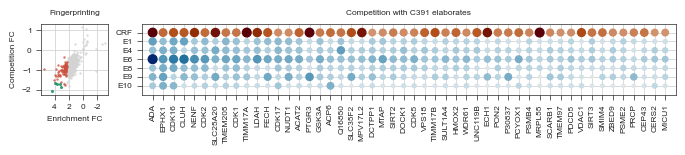

In [30]:
identifiers = [
 'PC_C391_F__CRF',
 'PC_C391_E1_20x__PC_C391_F',
 'PC_C391_E4_20x__PC_C391_F',
 'PC_C391_E6_20x__PC_C391_F',
 'PC_C391_E8_20x__PC_C391_F',
 'PC_C391_E9_20x__PC_C391_F',
 'PC_C391_E10_20x__PC_C391_F']

synonyms = [
    'CRF',
    'E1',
    'E4',
    'E6',
    'E8',
    'E9',
    'E10']


fig, axs = stylia.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.96, height=ONE_COLUMN_WIDTH/2.3, width_ratios=[1, 8])
ax = axs.next()
stylia.label(ax, xlabel="Enrichment FC", ylabel="Competition FC", title="Fingerprinting")
d = data_scatter

c = NamedColors()

d_ = d[(d["enrichment"] == "enriched")]
d_ = d_[d_["competition"] == "not competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_["log2_competition_ratio"]
print(d_.shape)
ax.scatter(x,y, s=3, lw=0, color=c.red, zorder=2, alpha=0.8)

d_ = d[(d["enrichment"] == "not enriched")]
d_ = d_[d_["competition"] == "competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_["log2_competition_ratio"]
ax.scatter(x,y, s=3, lw=0, color=c.blue, zorder=3, alpha=0.8)

d_ = d[(d["enrichment"] == "enriched")]
d_ = d_[d_["competition"] == "competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_["log2_competition_ratio"]
ax.scatter(x,y, s=5, lw=0, color=c.green, zorder=4, alpha=0.8)

d_ = d[(d["enrichment"] == "not enriched")]
d_ = d_[d_["competition"] == "not competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_["log2_competition_ratio"]
ax.scatter(x,y, s=3, lw=0, color=c.gray, zorder=1, alpha=0.8)

ax.set_xticks([-4, -2,  0, 2])
ax.set_xticklabels([4, 2, 0, -2])

ax = axs.next()

d = data_heatmap
sorted_genes = d[d["comparison"] == identifiers[0]].sort_values(by="fp_only_abs_sum", ascending=False)["Gene_Symbol"].tolist()[:50]

e_values = np.linspace(-4, 4, 100)
cmap_e = ContinuousColorMap("coolwarm", transformation="normal")
cmap_e.fit(e_values)
f_values = np.linspace(-5, 5, 100)
cmap_f = ContinuousColorMap("coolwarm", transformation="normal")
cmap_f.fit(f_values)

for i, identifier in enumerate(identifiers):
    d_ = d[d["comparison"] == identifier]
    d_ = d_[d_["Gene_Symbol"].isin(sorted_genes)]
    d_ = d_.sort_values(by="fp_only_abs_sum", ascending=False)
    x = [j for j in range(len(sorted_genes))]
    y = [i]*len(sorted_genes)
    v = np.array(d_["Abundance_Ratio_log2_"])
    if i == 0:
        colors = cmap_f.transform(v)
        f = 7
    else:
        f = 10
        colors = cmap_e.transform(v)
    ax.scatter(x,y, color=colors, s=np.abs(v)*f+1)

ax.set_xticks([j for j in range(len(sorted_genes))])
ax.set_xticklabels(sorted_genes, rotation=90, ha="center")
ax.set_yticks([i for i in range(len(identifiers))])
ax.set_yticklabels(synonyms)
ax.set_ylim(len(identifiers), -1)
ax.set_xlim(-1, 50)

stylia.label(ax, xlabel="", ylabel="", title="Competition with C391 elaborates")

stylia.save_figure("../assets/Figure03_DE.png")
stylia.save_figure("../assets/Figure03_DE.pdf")

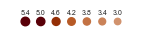

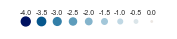

In [31]:
fig, axs = stylia.create_figure(1,1, width=ONE_COLUMN_WIDTH/2.5, height=ONE_COLUMN_WIDTH/10)
ax = axs.next()
v = np.arange(3, 5.4, 0.4)
f = 7
colors = cmap_f.transform(v)
ax.scatter([i for i in range(len(v))], [0]*len(v), s=v*f, color=colors)
ax.set_xlim(len(v),-1)
ax.set_ylim(-1, 1.3)
for i in range(len(v)):
    ax.text(i, 1.2, np.round(v[i], 1), va="center", ha="center")
ax.set_axis_off()
stylia.label(ax, xlabel="", ylabel="", title="")
stylia.save_figure("../assets/Figure03_E_legend_a.png")
stylia.save_figure("../assets/Figure03_E_legend_a.pdf")

fig, axs = stylia.create_figure(1,1, width=ONE_COLUMN_WIDTH/2, height=ONE_COLUMN_WIDTH/10)
ax = axs.next()
v = np.arange(-4, 0.5, 0.5)
f = 10
colors = cmap_e.transform(v)
ax.scatter([i for i in range(len(v))], [0]*len(v), s=np.abs(v)*f+1, color=colors)
for i in range(len(v)):
    ax.text(i, 1.2, np.round(v[i], 1), va="center", ha="center")
ax.set_xlim(-1, len(v))
ax.set_ylim(-1, 1.3)

ax.set_axis_off()
stylia.label(ax, xlabel="", ylabel="", title="")
stylia.save_figure("../assets/Figure03_E_legend_b.png")
stylia.save_figure("../assets/Figure03_E_legend_b.pdf")

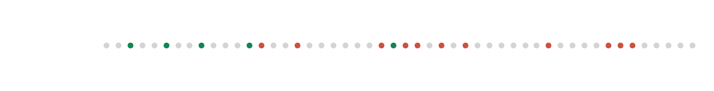

In [34]:
fig, axs = stylia.create_figure(1,2, width=TWO_COLUMNS_WIDTH, height=ONE_COLUMN_WIDTH/4, width_ratios=[1, 8])
ax = axs.next()
ax.set_axis_off()
stylia.label(ax, "", "", "")
ax = axs.next()
stylia.label(ax, xlabel="Enrichment FC", ylabel="Competition FC", title="Fingerprinting")

d = data_scatter

c = NamedColors()

d_ = d[(d["enrichment"] == "enriched")]
d_ = d_[d_["competition"] == "competed"]
green_genes = set(d_["Gene_Symbol"])
d_ = d[(d["enrichment"] == "enriched")]
d_ = d_[d_["competition"] == "not competed"]
red_genes = set(d_["Gene_Symbol"])

for i, g in enumerate(sorted_genes):
    color = None
    if g in green_genes:
        color = c.green
    if g in red_genes:
        color = c.red
    if color is None:
        color = c.gray
    ax.scatter([i], [0], color=color)

ax.set_xlim(-1, 50)
ax.set_ylim(-1, 1)
ax.set_yticks([0])
ax.set_yticklabels(["CRF"])
ax.grid()
ax.set_axis_off()

stylia.label(ax, xlabel="", ylabel="", title="")
stylia.save_figure("../assets/Figure03_E_legend_c.png")
stylia.save_figure("../assets/Figure03_E_legend_c.pdf")

{'GPR107': 6.17, 'NAMPT': 6.1, 'SLC2A4': 6.03, 'TIMM17A': 5.34, 'FKBP7': 5.14, 'APOL2': 5.14, 'NELFCD': 4.96, 'SLC35F2': 4.96, 'TSPAN3': 4.93, 'LNPEP': 4.9, 'SCPEP1': 4.85, 'TTYH3': 4.84, 'PPT1': 4.7, 'B4GAT1': 4.7, 'GOLIM4': 4.64, 'PRCP': 4.61, 'ZADH2': 4.55, 'SLC25A20': 4.46, 'LGMN': 4.34, 'TLCD1': 4.32, 'PCYOX1': 4.15, 'CERS1': 4.15, 'ECE1': 4.14, 'SORT1': 4.11, 'DDB1': 4.05, 'TSPAN6': 4.04, 'Q16850': 4.04, 'GLB1': 4.04, 'ERGIC3': 3.99, 'CLCN3': 3.98, 'STX6': 3.98, 'NPC1': 3.92, 'TMEM87A': 3.9, 'PSMA6': 3.87, 'KCT2': 3.87, 'FDFT1': 3.84, 'SV2A': 3.84, 'CPVL': 3.83, 'GLG1': 3.77, 'IDH1': 3.74, 'TGOLN2': 3.74, 'MTBP': 3.73, 'SCARB1': 3.7, 'MRC2': 3.66, 'TM9SF3': 3.66, 'NENF': 3.65, 'TMEM97': 3.57, 'ATP7A': 3.53, 'KDSR': 3.52, 'ASAH1': 3.48}


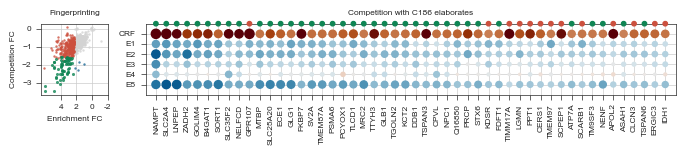

In [82]:
dc = pd.read_csv("../data/competitome_2304.tsv", sep="\t")
dc_ = dc[dc["fp_parent_fragment"] == "C186"]

dc_ = dc_.sort_values(by="fp_Number_of_Protein_Unique_Peptides", ascending=False)
dc_ = dc_.sort_values(by="enrichment_log2_ratio", ascending=False)
dc_ = dc_[dc_["fp_Number_of_Protein_Unique_Peptides"] >= 2]


identifiers = [
 'PC_C186_E1_20x',
 'PC_C186_E2_20x',
 'PC_C186_E3_20x',
 'PC_C186_E4_20x',
 'PC_C186_E5_20x']

synonyms = [
    'E1',
    'E2',
    'E3',
    'E4',
    'E5']

fig, axs = stylia.create_figure(1,2, width=TWO_COLUMNS_WIDTH*0.96, height=ONE_COLUMN_WIDTH/2.3, width_ratios=[1, 8])
ax = axs.next()
stylia.label(ax, xlabel="Enrichment FC", ylabel="Competition FC", title="Fingerprinting")
d = dc_[dc_["fp_fragment"] == identifiers[4]]

c = NamedColors()

d_ = d[(d["enrichment"] == "enriched")]
d_ = d_[d_["competition"] == "not competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_['competition_log2_ratio']
red_genes = set(d_["fp_Gene_Symbol"].tolist())
ax.scatter(x,y, s=3, lw=0, color=c.red, zorder=2, alpha=0.8)

d_ = d[(d["enrichment"] == "not enriched")]
d_ = d_[d_["competition"] == "competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_['competition_log2_ratio']
blue_genes = set(d_["fp_Gene_Symbol"].tolist())
ax.scatter(x,y, s=3, lw=0, color=c.blue, zorder=3, alpha=0.8)

d_ = d[(d["enrichment"] == "enriched")]
d_ = d_[d_["competition"] == "competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_['competition_log2_ratio']
green_genes = set(d_["fp_Gene_Symbol"].tolist())
ax.scatter(x,y, s=5, lw=0, color=c.green, zorder=4, alpha=0.8)

d_ = d[(d["enrichment"] == "not enriched")]
d_ = d_[d_["competition"] == "not competed"]
x = d_["log2_inverted_enr_ratio"]
y = d_['competition_log2_ratio']
ax.scatter(x,y, s=3, lw=0, color=c.gray, zorder=1, alpha=0.8)

ax.set_xticks([-4, -2,  0, 2])
ax.set_xticklabels([4, 2, 0, -2])

ax = axs.next()

import collections
protein_values = collections.defaultdict(list)
for r in dc_[["fp_Gene_Symbol", "enrichment_log2_ratio"]].values:
    protein_values[r[0]] += [r[1]]
protein_values = dict((k, np.mean(v)) for k,v in protein_values.items())
protein_values = sorted(protein_values.items(), key=lambda x: -x[1])[:100]

dc_ = dc_[dc_["fp_Gene_Symbol"].isin([x[0] for x in protein_values])]

protein_values = dict((k, [v]) for k,v in protein_values)
for r in dc_[["fp_Gene_Symbol", "competition_log2_ratio"]].values:
    protein_values[r[0]] += [np.abs(r[1])]

protein_values = dict((k, np.sum(v)) for k,v in protein_values.items())
protein_values = sorted(protein_values.items(), key=lambda x: -x[1])[:50]

sorted_genes = [x[0] for x in protein_values]

d = dc_

e_values = np.linspace(-4, 4, 100)
cmap_e = ContinuousColorMap("coolwarm", transformation="normal")
cmap_e.fit(e_values)
f_values = np.linspace(-5, 5, 100)
cmap_f = ContinuousColorMap("coolwarm", transformation="normal")
cmap_f.fit(f_values)

coordinates = {}
for i, identifier in enumerate(identifiers):
    for j, gene_name in enumerate(sorted_genes):
        coordinates[(identifier, gene_name)] = (i+1,j)

identifiers = ["CRF"] + identifiers

for i, identifier in enumerate(identifiers):
    if i == 0:
        d_ = d[d['fp_fragment'] == identifiers[-1]]
        d_ = d_[d_["fp_Gene_Symbol"].isin(sorted_genes)]
        x = []
        y = []
        v = []
        v_dict = {}
        for gn, v_ in d_[["fp_Gene_Symbol", "enrichment_log2_ratio"]].values:
            v_dict[gn] = v_
        print(v_dict)
        v = [v_dict[gn] for gn in sorted_genes]
        y = [0]*len(v)
        x = [i for i in range(len(sorted_genes))]
        f = 7
        colors = cmap_f.transform(v)
    else:
        d_ = d[d['fp_fragment'] == identifier]
        d_ = d_[d_["fp_Gene_Symbol"].isin(sorted_genes)]
        x = []
        y = []
        v = []
        for gn, v_ in d_[["fp_Gene_Symbol", "competition_log2_ratio"]].values:
            y += [i]
            x += [coordinates[(identifier, gn)][1]]
            v += [v_]
        f = 10
        colors = cmap_e.transform(v)
    ax.scatter(x,y, color=colors, s=np.abs(v)*f+1)

ax.set_xticks([j for j in range(len(sorted_genes))])
ax.set_xticklabels(sorted_genes, rotation=90, ha="center")
ax.set_yticks([i for i in range(len(identifiers))])
ax.set_yticklabels(["CRF"] + synonyms)
ax.set_ylim(len(identifiers), -1)
ax.set_xlim(-1, 50)

stylia.label(ax, xlabel="", ylabel="", title="Competition with C186 elaborates")

x = []
y = []
c = []
for i, gn in enumerate(sorted_genes):
    y += [-1]
    x += [i]
    if gn in green_genes:
        c += [NamedColors().green]
    elif gn in red_genes:
        c += [NamedColors().red]
    else:
        c += [NamedColors().gray]
ax.scatter(x, y, color=c, clip_on=False, zorder = 100000)

stylia.save_figure("../assets/Figure03_HI.png")
stylia.save_figure("../assets/Figure03_HI.pdf")